In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc

### assessments
этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
- `code_module` — идентификационный код предмета.
- `code_presentation` — семестр (Идентификационный код).
- `id_assessment` — тест (Идентификационный номер ассессмента).
- `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
- `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
- `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [3]:
assessments = pd.read_csv('assessments.csv')
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### courses
файл содержит список предметов по семестрам.
- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код).
- `module_presentation_length` — продолжительность семестра в днях.

In [4]:
courses = pd.read_csv('courses.csv')
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


### studentAssessment
этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

- `id_assessment` — тест (идентификационный номер).

- `id_student` — идентификационный номер студента.

- `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [5]:
studentAssessment = pd.read_csv('studentAssessment.csv')
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [6]:
studentAssessment.query('score == "nan"').id_assessment

Series([], Name: id_assessment, dtype: int64)

### studentRegistration
этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код)
- `id_student` — идентификационный номер студента.
- `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
- `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [7]:
studentRegistration = pd.read_csv('studentRegistration.csv')
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [8]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

## <span style="color:FireBrick">1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).</span>

### <span style="color:SteelBlue">Решение</span>

####  <span style="color:DarkGreen">1. Во-первых - нас интересуют лишь прошедшие курс ученики, а это мы можем узнать следующим образом: </span>
   - Поскольку поле `date_unregistration` в таблице `studentRegistration` у студентов, окончивших курс, остается пустым, то мы находим лишь тех студентов, которые сохранились в бд без отмены регистрации. 
   - Ищем в таблице `studentAssessment` значения id_student схожие со списком предобработанных значений из таблицы `studentRegistration`

In [9]:
register_students = studentRegistration.query('date_unregistration.isna() == True').id_student.unique()
register_students = studentAssessment[studentAssessment['id_student'].isin(register_students)]
register_students

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


#### <span style="color:DarkGreen">2. Во-вторых, в условии задачи сказано, что успешная сдача курса - это зачет по курсу на экзамене, а значит нашу предыдущую таблицу необходимо сопоставить с таблицей assessments, в которой мы отберем только экзамен. А также отсеем учеников, которые не сдали экзамен, то есть набрали меньше 40 баллов. </span>

In [10]:
graduate_students = assessments.query('assessment_type == "Exam"') \
    .merge(register_students, on = 'id_assessment') \
    .query('score >= 40')
graduate_students.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
5,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0


Заодно проверим нет ли в наших данных ошибки, поскольку если бы студент не зарегистрировался на курс и прошел его, то мы бы получили данных больше, чем если бы не выполняли первый пункт

<span style="color:Tomato">**Проверим наши данные:**</span>

In [11]:
all_students = assessments.merge(register_students, on = 'id_assessment')
all_students

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0
...,...,...,...,...,...,...,...,...,...,...
163921,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0
163922,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0
163923,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0
163924,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0


In [12]:
graduate_students.shape == all_students.query('assessment_type == "Exam" & score >= 40').shape

True

С данными все в порядке, мы получили одинаковое количество строк

#### <span style="color:DarkGreen">3. Посмотрим по каким предметам проводятся экзамены за все годы и по каждому году отдельно</span>

In [47]:
graduate_students

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,year_and_module,success_passed
2116,DDD,2013B,25340,Exam,240.0,100.0,477451,229,0,56.0,2013B / DDD,1
2080,DDD,2013B,25340,Exam,240.0,100.0,441302,229,0,76.0,2013B / DDD,1
2294,DDD,2013B,25340,Exam,240.0,100.0,546826,229,0,56.0,2013B / DDD,1
2325,DDD,2013B,25340,Exam,240.0,100.0,550604,229,0,62.0,2013B / DDD,1
2085,DDD,2013B,25340,Exam,240.0,100.0,443215,229,0,44.0,2013B / DDD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1706,CCC,2014J,24299,Exam,NaN,100.0,352637,259,0,96.0,2014J / CCC,1
1143,CCC,2014J,24299,Exam,NaN,100.0,634824,259,0,42.0,2014J / CCC,1
738,CCC,2014B,24290,Exam,NaN,100.0,555008,266,0,56.0,2014B / CCC,1
4319,DDD,2014J,25368,Exam,NaN,100.0,2341830,279,0,49.0,2014J / DDD,1


<Figure size 1000x700 with 0 Axes>

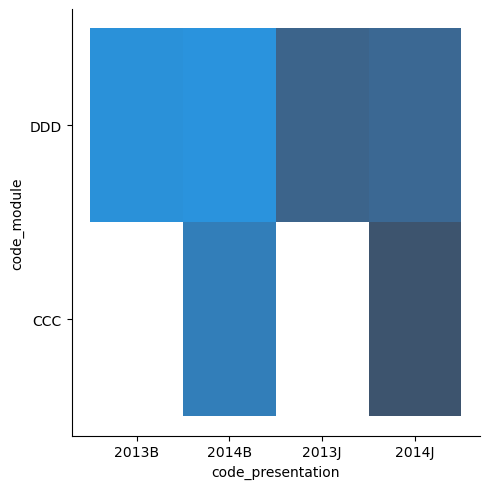

In [60]:
plt.figure(figsize= (10,7))
sns.displot(data = graduate_students, y = 'code_module', x = 'code_presentation')
sns.despine()

#### <span style="color:DarkGreen">4. Проверим количество студентов обучающихся на сессиях</span>

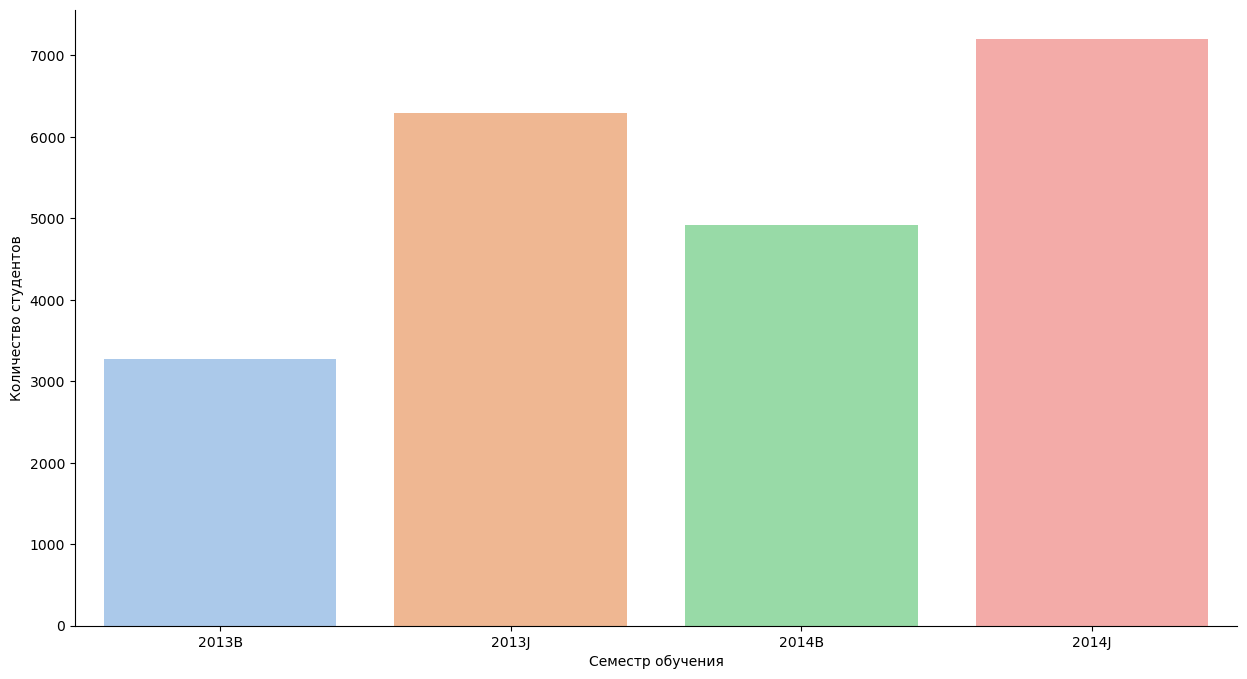

In [14]:
count_all_std = all_students.groupby('code_presentation', as_index = False).agg({'id_student':'nunique'})
plt.figure(figsize= (15,8))
ax = sns.barplot(data = count_all_std, x = 'code_presentation', y = 'id_student',
                palette = 'pastel')
ax.set_xlabel('Семестр обучения')
ax.set_ylabel('Количество студентов')
sns.despine()

In [15]:
count_all_std

,code_presentation,id_student
0,2013B,3270
1,2013J,6289
2,2014B,4919
3,2014J,7199


#### <span style="color:DarkGreen">5. Посмотрим поближе на данные в таблице courses и таблице assesment, в которой мы отобрали только экзамены, сделав из нее таблицу graduate_students</span>

In [16]:
lenght_courses = courses.query('code_module == "CCC" or code_module == "DDD"').copy()
lenght_courses['year_and_module'] =  lenght_courses.code_presentation + ' / ' + lenght_courses.code_module
lenght_courses

,code_module,code_presentation,module_presentation_length,year_and_module
6,CCC,2014J,269,2014J / CCC
7,CCC,2014B,241,2014B / CCC
8,DDD,2013J,261,2013J / DDD
9,DDD,2014J,262,2014J / DDD
10,DDD,2013B,240,2013B / DDD
11,DDD,2014B,241,2014B / DDD


In [17]:
graduate_students = graduate_students.sort_values('date_submitted')
graduate_students['year_and_module'] = graduate_students.code_presentation + ' / ' + graduate_students.code_module
graduate_students

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,year_and_module
2116,DDD,2013B,25340,Exam,240.0,100.0,477451,229,0,56.0,2013B / DDD
2080,DDD,2013B,25340,Exam,240.0,100.0,441302,229,0,76.0,2013B / DDD
2294,DDD,2013B,25340,Exam,240.0,100.0,546826,229,0,56.0,2013B / DDD
2325,DDD,2013B,25340,Exam,240.0,100.0,550604,229,0,62.0,2013B / DDD
2085,DDD,2013B,25340,Exam,240.0,100.0,443215,229,0,44.0,2013B / DDD
...,...,...,...,...,...,...,...,...,...,...,...
1706,CCC,2014J,24299,Exam,NaN,100.0,352637,259,0,96.0,2014J / CCC
1143,CCC,2014J,24299,Exam,NaN,100.0,634824,259,0,42.0,2014J / CCC
738,CCC,2014B,24290,Exam,NaN,100.0,555008,266,0,56.0,2014B / CCC
4319,DDD,2014J,25368,Exam,NaN,100.0,2341830,279,0,49.0,2014J / DDD


In [18]:
diff_dates = graduate_students[['date_submitted', 'year_and_module']] \
                                            .merge(lenght_courses, on = 'year_and_module')
diff_dates['diff_btw_days'] = diff_dates.module_presentation_length - \
                                            diff_dates.date_submitted
diff_dates.sort_values('diff_btw_days')

,date_submitted,year_and_module,code_module,code_presentation,module_presentation_length,diff_btw_days
1167,266,2014B / CCC,CCC,2014B,241,-25
3372,279,2014J / DDD,DDD,2014J,262,-17
4391,285,2014J / CCC,CCC,2014J,269,-16
1652,251,2014B / DDD,DDD,2014B,241,-10
1166,242,2014B / CCC,CCC,2014B,241,-1
...,...,...,...,...,...,...
3471,243,2014J / CCC,CCC,2014J,269,26
3470,243,2014J / CCC,CCC,2014J,269,26
3469,243,2014J / CCC,CCC,2014J,269,26
3466,243,2014J / CCC,CCC,2014J,269,26


<span style="color:Tomato">**на основе полученных данных из пунктов 3, 4 и 5 - делаем выводы:**</span>

1. В 2013 году экзамен проводился лишь по предмету - DDD, а в 2014 году добавился экзамен - CCC
2. Буквенные обозначения B и J судя по количеству увеличивающихся студентов обозначают летнюю и зимнюю сессию соответственно, поскольку с каждой новой сессией в новом году студенты прибавляются.
3. Из пункта 5 делаем вывод: 
    - Колонка `module_presentation_length` в таблице `courses` означает продолжительность семестра в днях
    - При подробном рассмотрении таблицы `graduate_students` в которую мы отобрали только экзамены, которые сдавали студенты, мы обнаружим колонку `date_submitted` со значениями, которые очень близки к значениям `module_presentation_length`. 
    - Произведя объединение данных на основе года и предмета по этим таблицам мы находим, истинную разницу в днях между продолжительностью курса и датой сдачи экзамена учениками. 
    - При условии, что успешная сдача - это зачет по **курсу** на экзамене, а длительность курса(длительность до сдачи экзамена в днях) практически равна длительности семестра - делаем вывод: <span style="color:Tomato">курсом является предмет, в конкретном семестре</span>

In [19]:
graduate_students.drop(columns = 'year_and_module')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
2116,DDD,2013B,25340,Exam,240.0,100.0,477451,229,0,56.0
2080,DDD,2013B,25340,Exam,240.0,100.0,441302,229,0,76.0
2294,DDD,2013B,25340,Exam,240.0,100.0,546826,229,0,56.0
2325,DDD,2013B,25340,Exam,240.0,100.0,550604,229,0,62.0
2085,DDD,2013B,25340,Exam,240.0,100.0,443215,229,0,44.0
...,...,...,...,...,...,...,...,...,...,...
1706,CCC,2014J,24299,Exam,NaN,100.0,352637,259,0,96.0
1143,CCC,2014J,24299,Exam,NaN,100.0,634824,259,0,42.0
738,CCC,2014B,24290,Exam,NaN,100.0,555008,266,0,56.0
4319,DDD,2014J,25368,Exam,NaN,100.0,2341830,279,0,49.0


In [20]:
# В отобранной таблице успешно сдавших экзамен студентов добавляю единицу, означающую успешную сдачу 1 экзамена

graduate_students['success_passed'] = 1

In [21]:
succ_passed_only_one = graduate_students.groupby('id_student') \
                                        .agg({'success_passed':'sum'}) \
                                        .query('success_passed == 1')
succ_passed_only_one.count()

success_passed    3802
dtype: int64

### <span style="color:SteelBlue">Ответ:</span>
Успешно сдали курс только один раз 3802 студента

## <span style="color:FireBrick">2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)</span>

*<span style="color:Tomato">завершаемость</span> = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

### <span style="color:SteelBlue">Решение</span>

#### <span style="color:DarkGreen">1. Для того, чтобы посмотреть на завершаемость курсов, необходимо отобрать из таблицы `all_students` все экзамены</span>

In [22]:
all_exams = all_students.query('assessment_type == "Exam"')
all_exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
49968,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
49969,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
49970,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
49971,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
49972,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
89420,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
89421,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
89422,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
89423,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


#### <span style="color:DarkGreen">2. А теперь сравнить таблицу `all_exams` с таблицей `graduate_students`</span>

In [23]:
success_exams = graduate_students.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg({'id_assessment':'count'})  \
                  .sort_values('id_assessment', ascending = False)
success_exams

,code_presentation,code_module,id_assessment
4,2014J,CCC,1019
1,2013J,DDD,878
5,2014J,DDD,842
2,2014B,CCC,664
0,2013B,DDD,504
3,2014B,DDD,485


In [24]:
whole_exams = all_exams.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg({'id_assessment':'count'})  \
                  .sort_values('id_assessment', ascending = False)
whole_exams

,code_presentation,code_module,id_assessment
4,2014J,CCC,1168
1,2013J,DDD,967
5,2014J,DDD,950
2,2014B,CCC,747
0,2013B,DDD,602
3,2014B,DDD,524


In [25]:
success_exams['peace_of_success'] = success_exams.id_assessment / whole_exams.id_assessment
success_exams = success_exams.sort_values('peace_of_success')
success_exams

,code_presentation,code_module,id_assessment,peace_of_success
0,2013B,DDD,504,0.837209
4,2014J,CCC,1019,0.872432
5,2014J,DDD,842,0.886316
2,2014B,CCC,664,0.888889
1,2013J,DDD,878,0.907963
3,2014B,DDD,485,0.925573


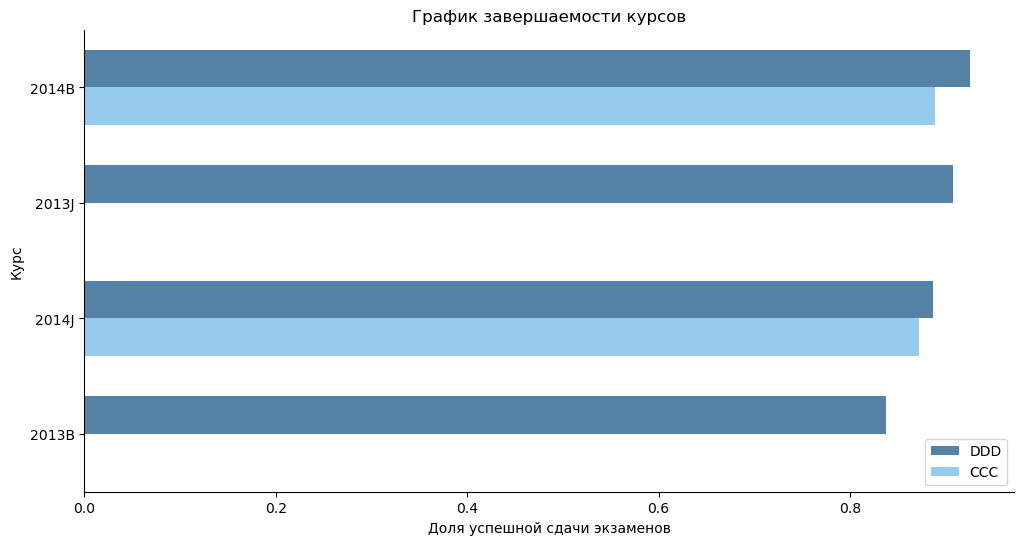

In [26]:
plt.figure(figsize = (12,6))
ax = sns.barplot(data = success_exams, x = 'peace_of_success', y = 'code_presentation', 
                 hue = 'code_module', 
                 order = ['2014B', '2013J', '2014J', '2013B'],
                 orient = "h", 
                 palette = ('SteelBlue', 'LightSkyBlue'),
                 width = 0.65)
ax.set_title('График завершаемости курсов', fontsize='large')
ax.set_xlabel('Доля успешной сдачи экзаменов')
ax.set_ylabel('Курс')
plt.legend(loc='lower right')
sns.despine()

### <span style="color:SteelBlue">Ответ:</span>

- Благодаря графику мы можем увидеть, что самая высокая завершаемость курса у экзамена DDD в 2014B сессии, а значит самым простым экзаменом является экзамен DDD/2014B. 
- Самая низкая завершаемость у курса DDD в 2013B сессии, а значит самым сложным экзаменом стал DDD/2013B. 

## <span style="color:FireBrick">3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов) </span>

#### <span style="color:DarkGreen">1. Предметы у нас записаны в колонке `code_module` таблицы `assessments`. В данной задаче нам необходимо найти только те предметы, по которым у нас есть экзамены, а для этого уже есть подготовленная табличка, в которой собраны все сдачи студентов - `all_exams`</span>

In [27]:
all_exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
49968,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
49969,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
49970,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
49971,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
49972,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
89420,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
89421,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
89422,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
89423,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


#### <span style="color:DarkGreen">2. Для нахождения среднего значения колонки `date_submitted` необходимо просто сгруппировать значения по колонке `code_module` и, сагрегировав данные найти среднее значение.</span>

In [28]:
avg_exams = graduate_students.groupby('code_module', as_index = False) \
                  .agg({'date_submitted':'mean'})  \
                  .sort_values('date_submitted', ascending = False) \
                  .round(2)
avg_exams

,code_module,date_submitted
0,CCC,239.35
1,DDD,237.98


#### <span style="color:DarkGreen">Но я уже посмотрел первый урок по статистике и решил проверить насколько валидно в принципе использовать среднее значение на наших данных. Поэтому я решил построить графики для </span>

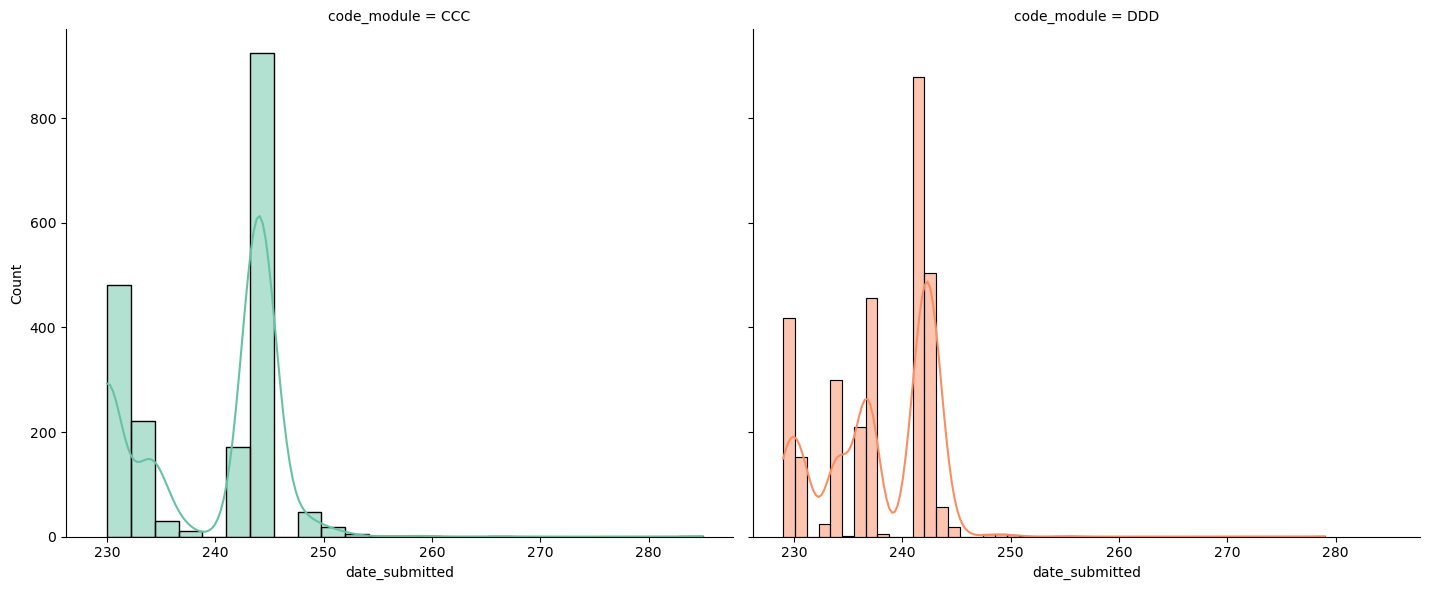

In [29]:
color = sns.color_palette("Set2")
g = sns.FacetGrid (data = all_exams, col = 'code_module', hue = 'code_module',
                   col_wrap = 2, height = 6, aspect = 1.2,
                   palette = color)
g.map(sns.histplot, 'date_submitted', kde=True)
sns.despine()

<span style="color:Tomato">**Из полученных графиков делаем выводы:**</span>

1. Распределения данных не относятся к нормальным, имеет несколько мод, а также есть выбросы, что в совокупности говорит нам о том, что в качестве меры центральной тенденции лучше не брать среднеарифметическое значение.
2. Остается два варианта медиана и мода. Рассматривая график срока сдачи экзамена CCC в качестве меры центральной тенденции можно смело выбирать моду, поскольку большинство значений собрано вокруг одного числа. Поэтому для экзамена CCC средним значением будет являться мода
3. А вот на графике с экзаменом DDD мы видим несколько мод, которые не так явно различаются между собой, как на экзамене CCC. Поэтому для данного экзамена в качестве среднего значения я выберу медиану, которая будет лучше отражать среднее значение в наших данных.

In [38]:
CCC_mode = sc.mode(all_exams.query('code_module == "CCC"').date_submitted)
DDD_median = np.median(all_exams.query('code_module == "DDD"').date_submitted)

### <span style="color:SteelBlue">Ответ:</span>

In [39]:
print(f'Средний срок сдачи CCC экзамена равно {CCC_mode[0][0]},а средний срок сдачи DDD экзамена равен {round(DDD_median)}')

Средний срок сдачи CCC экзамена равно 244,а средний срок сдачи DDD экзамена равен 237
